In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mat
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import norm, t
from pygam import LinearGAM, s
sns.set(style="whitegrid", font_scale=1.1)

df_species = pd.read_csv("data/processed/species.csv")
df_sites = pd.read_csv("data/processed/sites.csv")
df_observations = pd.read_csv("data/processed/observations.csv")

In this notebook, we will study the evolution of population for given species of birds, and calculate Confidence Intervals.


In [37]:
# Evolutions of species
species = df_observations["clean_espece"].unique()
evolutionSpecies = {name : pd.Series() for name in species}

for sp in species:
    df_cut = df_observations[df_observations["clean_espece"] == sp]
    evolution = df_cut.groupby("year")["Amount"].sum()
    if 2014 in evolution.keys():
        evolution = evolution.drop(2014)
    evolutionSpecies[sp] = evolution
evolutionSpecies = pd.Series(evolutionSpecies)

In [38]:
# Identify the species which are decreasing the most
changeSpecies = pd.Series(index = species)
length = 2025 - 2014 + 1

for sp in species:
    evol = evolutionSpecies[sp]
    lastInd = len(evol) - 1
    if lastInd > -1 and evol.iat[0] != 0.0:
        changeSpecies[sp] = 100*(evol.iat[lastInd] - evol.iat[0]) / evol.iat[0]

In the cells above, we created two variables :

- ```evolution_species``` which store for each species their population each year
- ```evolution_change``` which store the increase (or decrease) between the first and last year

We deleted the year 2014 because, as the observations began in the middle of the year, the number of observations for this year 
is way too low compared to others, and will give wrong informations for the population evolution.

Now, we are going to identify two species :
- The species who had the biggest decrease of their population.
- The species who had the biggest increase of their population.

Also we defined a threshold, considering only species who had been observed at least 220 times the first year to avoid unrepresentative data.

In [39]:
seuil = 220
minEsp, maxEsp = None, None
minChange, maxChange = np.inf, -np.inf 

for sp in species:
    evol = evolutionSpecies[sp]
    rateChange = changeSpecies[sp]

    if len(evol) > 0 and not(pd.isna(rateChange)) and evol.iat[0] > seuil :
        if rateChange < minChange:
            minChange = rateChange
            minEsp = sp 
        if rateChange > maxChange:
            maxChange = rateChange
            maxEsp = sp

maxEvol = evolutionSpecies[maxEsp]
popBegin = maxEvol.iat[0]
popEnd = maxEvol.iat[len(maxEvol) - 1]
change = changeSpecies[maxEsp]
print(f"The species of bird that had the biggest increase of its population between 2015 and 2025 is the {maxEsp}")
print(f"They went from a population of {popBegin} in 2015 to {popEnd}, increasing by {change:.2f} %.")
print("---------------------------------------------------------------------------------------------")

minEvol = evolutionSpecies[minEsp]
popBegin = minEvol.iat[0]
popEnd = minEvol.iat[len(minEvol) - 1]
change = changeSpecies[minEsp]
print(f"The species of bird that had the biggest decrease of its population between 2015 and 2025 is the {minEsp}")
print(f"They went from a population of {popBegin} in 2015 to {popEnd}, decreasing by {np.abs(change):.2f} %.")
print("---------------------------------------------------------------------------------------------")
years = maxEvol.keys()

The species of bird that had the biggest increase of its population between 2015 and 2025 is the tourterelle turque
They went from a population of 329.0 in 2015 to 885.0, increasing by 169.00 %.
---------------------------------------------------------------------------------------------
The species of bird that had the biggest decrease of its population between 2015 and 2025 is the colibri falle-vert
They went from a population of 236.0 in 2015 to 108.0, decreasing by 54.24 %.
---------------------------------------------------------------------------------------------


We have identified two species : 
- The `colibri falle-vert` is the species with the biggest decrease of population (-53.54%).
- The `tourterelle turque` is the species with the biggest increase of population (+169%).

Now we are going to plot the data on a graph and use a linear model to help predict the amount of observations for the next years.
We are also going to calculated the Confidence Interval for the model.

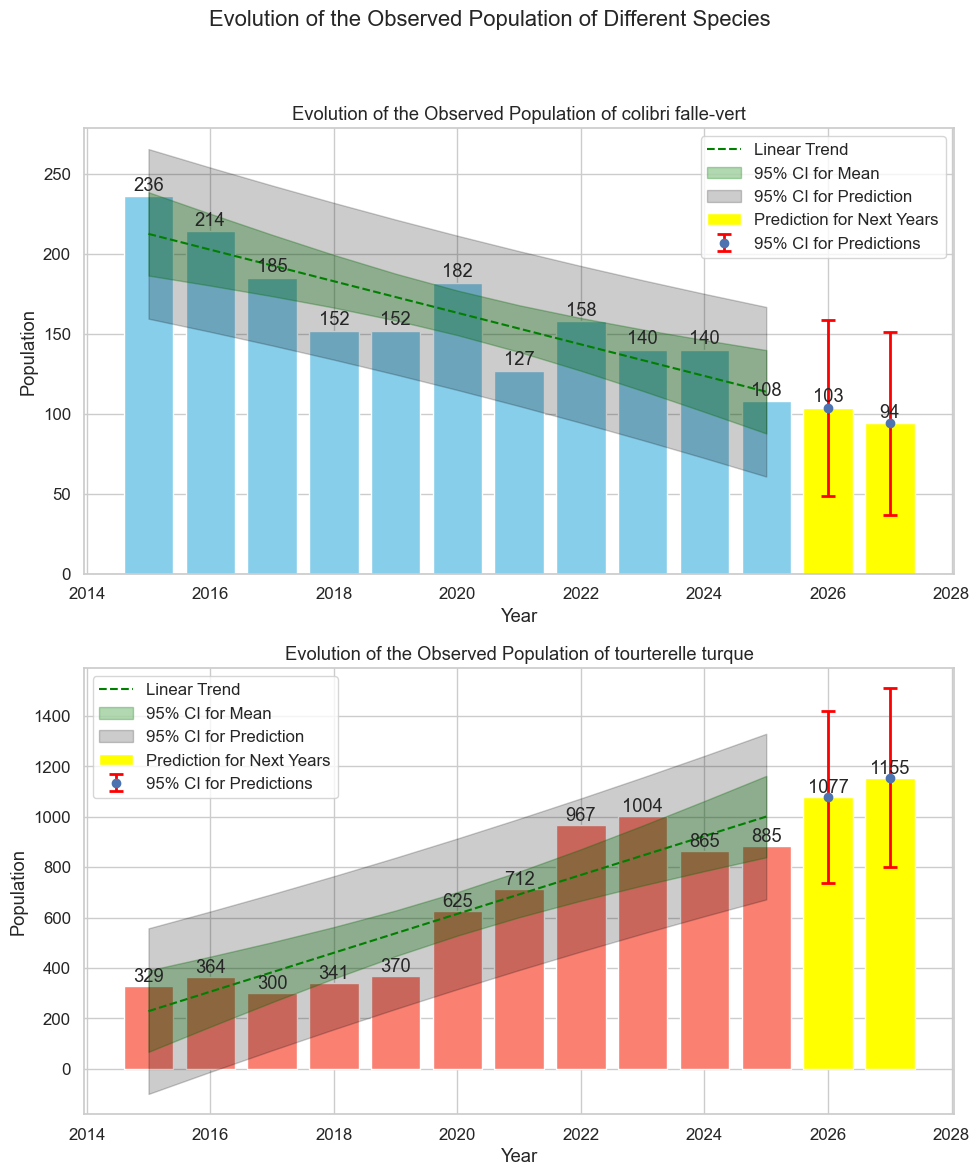

In [40]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

def ci_linear_model(x, Y_real, Y_model, alpha=0.05):
    n = len(x)
    x_mean = np.mean(x)
    
    # Residuals and variance estimates
    residues = Y_real - Y_model
    SSE = np.sum(np.square(residues))
    MSE = SSE / (n - 2)
    Sxx = np.sum(np.square(x - x_mean))

    # t critical value
    t_crit = t.ppf(1 - alpha / 2, n - 2)

    SE_mean = np.sqrt(MSE * (1/n + (x - x_mean)**2 / Sxx))
    SE_pred = np.sqrt(MSE * (1 + 1/n + (x - x_mean)**2 / Sxx))

    return t_crit * SE_mean, t_crit * SE_pred

def compute_ci_for_new_data(x_train, Y_real, Y_model, x_new, alpha=0.05):
    n = len(x_train)
    x_mean = np.mean(x_train)
    
    # Residuals and variance estimates from training data
    residues = Y_real - Y_model
    SSE = np.sum(np.square(residues))
    MSE = SSE / (n - 2)
    Sxx = np.sum(np.square(x_train - x_mean))

    # t critical value
    t_crit = t.ppf(1 - alpha / 2, n - 2)

    # CI for new data points
    SE_mean_new = np.sqrt(MSE * (1/n + (x_new - x_mean)**2 / Sxx))
    SE_pred_new = np.sqrt(MSE * (1 + 1/n + (x_new - x_mean)**2 / Sxx))

    return t_crit * SE_mean_new, t_crit * SE_pred_new

def plot_with_trend(ax, x, y, color, title):
    # Bar plot
    ax.bar(x, y, color=color)
    X = np.column_stack((x.values, np.ones(len(x))))
    
    model = LinearRegression()
    model.fit(X, y)
    next_years = np.array([np.array([max(x) + 1, 1]), np.array([max(x) + 2, 1])])
    b1 = model.coef_[0]           
    b0 = model.intercept_
    y_pred = model.predict(X)
    err, err2 = ci_linear_model(np.array(x), y, y_pred, 0.05)
    y_lower = y_pred - err
    y_upper = y_pred + err
    y_lower_pred = y_pred - err2
    y_upper_pred = y_pred + err2

    # Predictions for next years
    y_pred_next = model.predict(next_years)
    # CI for next years
    err_next, err2_next = compute_ci_for_new_data(np.array(x), y, y_pred, next_years[:, 0], 0.05)
    ax.plot(x, y_pred, color='green', linestyle='--', label='Linear Trend')

    # CI bands for training data
    ax.fill_between(x, y_lower, y_upper, color='green', alpha=0.3, label='95% CI for Mean')
    ax.fill_between(x, y_lower_pred, y_upper_pred, color='black', alpha=0.2, label='95% CI for Prediction')    
    ax.bar(next_years[:,0], y_pred_next, label="Prediction for Next Years", color="yellow")
    ax.errorbar(next_years[:,0], y_pred_next, yerr=err2_next, fmt='o', ecolor='red', capsize=5, capthick=2, linewidth=2, label='95% CI for Predictions')
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2, p.get_height() + 1, int(p.get_height()), ha='center', va='bottom')
    ax.set_title(title)
    ax.set_ylabel('Population')
    ax.set_xlabel('Year')
    ax.legend()

plot_with_trend(ax1, minEvol.keys(), minEvol, 'skyblue', f'Evolution of the Observed Population of {minEsp}')

# Plot maxEvol
plot_with_trend(ax2, maxEvol.keys(), maxEvol, 'salmon', f'Evolution of the Observed Population of {maxEsp}')
plt.suptitle("Evolution of the Observed Population of Different Species")

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
fig.savefig("figures/evolution_of_two_species.jpeg")
plt.show()

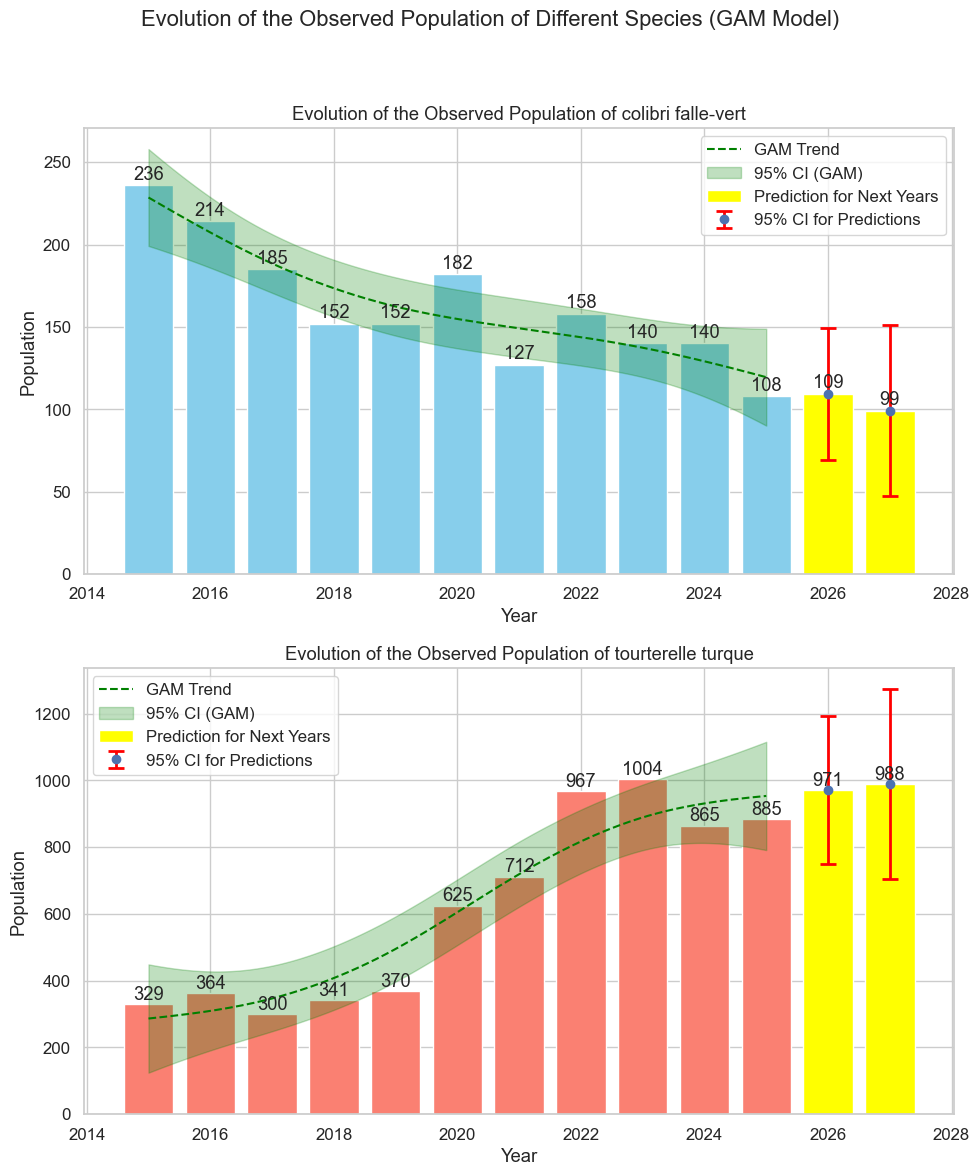

In [41]:
def plot_with_gam(ax, x, y, color, title):
    x_arr = np.asarray(list(x), dtype=float)
    y_arr = np.asarray(list(y), dtype=float)
    ax.bar(x_arr, y_arr, color=color)

    # Centering years for GAM to avoid artifacts
    x_mean = x_arr.mean()
    X = (x_arr - x_mean).reshape(-1, 1)

    # Reasonable number of splines given the few years
    n_spl = max(4, min(8, len(x_arr) - 1))
    gam = LinearGAM(s(0, n_splines=n_spl)).fit(X, y_arr)

    # Smooth curve on a dense grid (for a clean curve)
    x_grid = np.linspace(x_arr.min(), x_arr.max(), 200)
    X_grid = (x_grid - x_mean).reshape(-1, 1)
    y_pred = gam.predict(X_grid)
    ci_grid = gam.confidence_intervals(X_grid, width=0.95)

    ax.plot(x_grid, y_pred, color='green', linestyle='--', label='GAM Trend')
    ax.fill_between(x_grid, ci_grid[:, 0], ci_grid[:, 1], color='green', alpha=0.25, label='95% CI (GAM)')

    # Predictions for next years
    future_years = np.array([x_arr.max() + 1, x_arr.max() + 2], dtype=float)
    X_future = (future_years - x_mean).reshape(-1, 1)
    y_future = gam.predict(X_future)
    ci_future = gam.confidence_intervals(X_future, width=0.95)
    ax.bar(future_years, y_future, color='yellow', label='Prediction for Next Years')
    ax.errorbar(future_years, y_future,yerr=[y_future - ci_future[:, 0], ci_future[:, 1] - y_future],fmt='o', ecolor='red', capsize=6, capthick=2, linewidth=2, label='95% CI for Predictions')
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2, p.get_height() + 1,
                f"{int(round(p.get_height()))}", ha='center', va='bottom')
    ax.set_title(title)
    ax.set_ylabel('Population')
    ax.set_xlabel('Year')
    ax.legend()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
plot_with_gam(ax1, minEvol.index, minEvol.values, 'skyblue', f'Evolution of the Observed Population of {minEsp}')
plot_with_gam(ax2, maxEvol.index, maxEvol.values, 'salmon',f'Evolution of the Observed Population of {maxEsp}')
plt.suptitle("Evolution of the Observed Population of Different Species (GAM Model)")
plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.savefig("figures/evolution_of_two_species_gam.jpeg")
plt.show()

On the graph we have two Confidence Intervals for the data :

- The green one is the 95% confidence interval for the mean of the data, meaning that we are confident that if we resample the data, 
 95% of the time, the mean will be inside the interval confidence.
- The black one is the 95% interval confidence for the prediction of the linear model for the data.

Now that we have studied two species and their evolutions, we are going to study where these species lived, among the different types of habitat

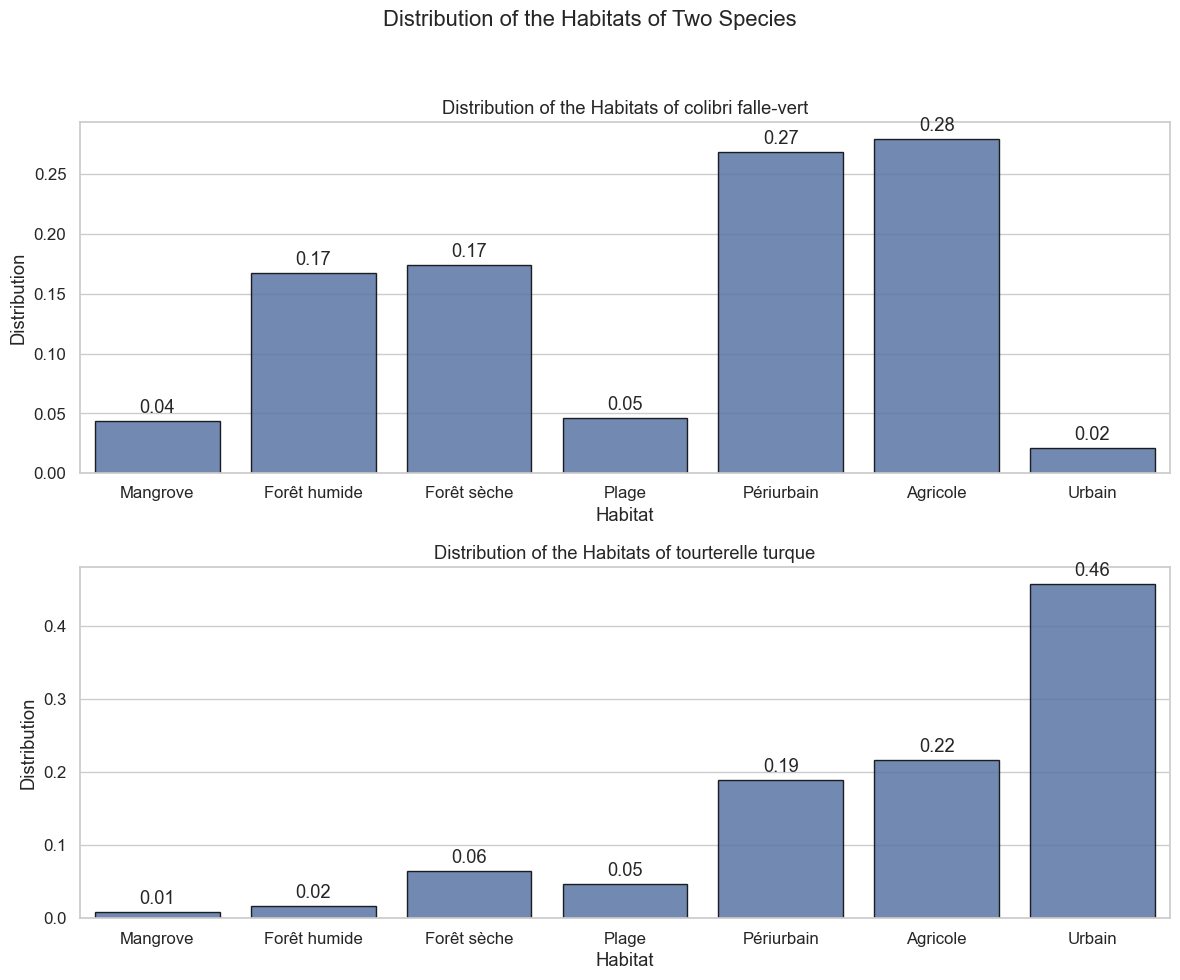

In [42]:
def get_habitat(sp):
    df_cut = df_observations[df_observations["clean_espece"] == sp]
    df_cut = df_cut[df_cut["year"] > 2014]
    habitats = pd.Series(0, index = df_sites["Type"].unique())

    for trans, idsite, amount in zip(df_cut["Nom transect"], df_cut["N° point"], df_cut["Amount"]):
        df_sites_cuts = df_sites[df_sites["Transect"] == trans]
        habitat = df_sites_cuts.iloc[int(idsite) - 1]["Type"]
        habitats[habitat] += amount 
    return habitats

habitatMin = get_habitat(minEsp)
habitatMax = get_habitat(maxEsp)
habitatMin = habitatMin / habitatMin.sum()
habitatMax = habitatMax / habitatMax.sum()

fig, axes = plt.subplots(2, 1, figsize =(12, 10))
sns.barplot(x=habitatMin.index, y=habitatMin.values, ax=axes[0], alpha=0.85, edgecolor="black")
axes[0].set_title(f"Distribution of the Habitats of {minEsp}")
axes[0].set_xlabel("Habitat")
axes[0].set_ylabel("Distribution")

sns.barplot(x=habitatMax.index, y=habitatMax.values, ax=axes[1], alpha=0.85, edgecolor="black")
axes[1].set_title(f"Distribution of the Habitats of {maxEsp}")
axes[1].set_xlabel("Habitat")
axes[1].set_ylabel("Distribution")

plt.suptitle("Distribution of the Habitats of Two Species")
plt.tight_layout(rect=[0, 0, 1, 0.95])  
for ax in axes:
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", padding=3)
fig.savefig("figures/distribution_habitats_of_two_species.jpeg")
plt.show()

We notice that the two species have very different habitats compared to each other, and that the distribution of their habitats is pretty diverse.

In [43]:
mask = evolutionSpecies.apply(lambda s: len(s) > 0 and s.iloc[0] > seuil)
new_series = evolutionSpecies[mask]

But now we are going to pick two new species :

- The first is the species with the biggest variance in the distribution of its habitats.
- The second one is the species with the lowest variance in the distribution of its habitats.

In clear, we are picking the species with the most widespread or variable habitats and the species with the most uniform or consistent habitats.

In [44]:
# Storing the stds
stdHabitats = pd.Series(0.0, new_series.keys())
stdMin , stdMax = np.inf, -np.inf

specieStdMin, specieStdMax = None, None
for sp in new_series.keys():
    hab = get_habitat(sp)
    hab = hab / hab.sum()
    std = hab.std()

    if std > stdMax:
        stdMax = std
        specieStdMax = sp
        habitatMax = hab
        
    if std < stdMin:
        stdMin = std
        specieStdMin = sp
        habitatMin = hab


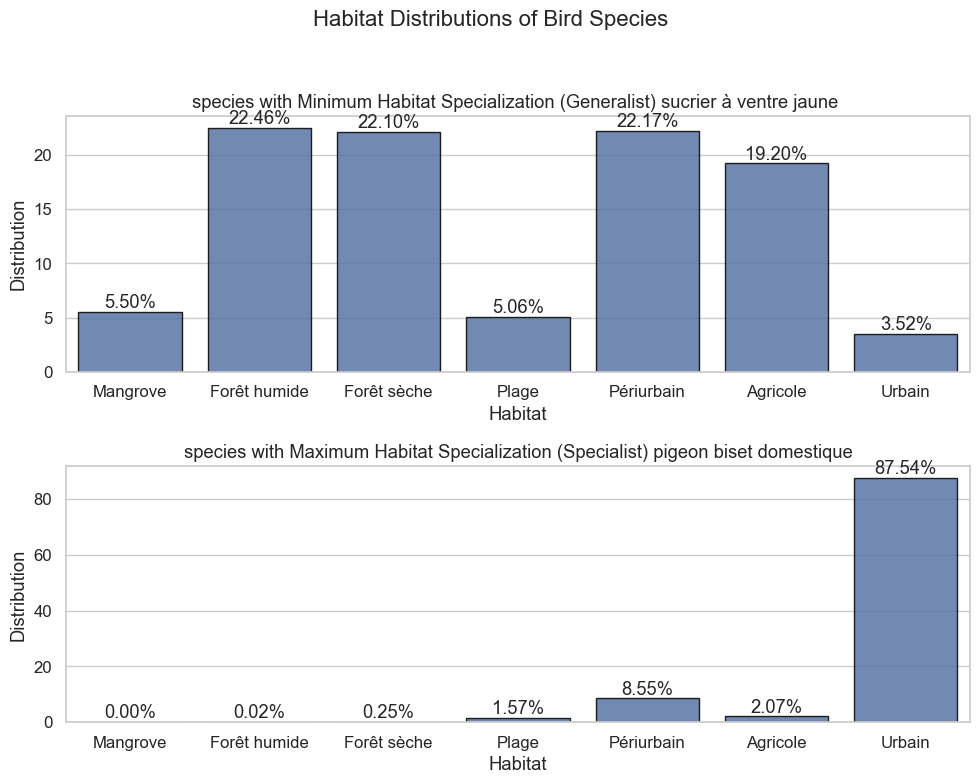

In [45]:
# Create figure with two subplots (vertical)
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot habitatMin
sns.barplot(x=habitatMin.index, y = 100 * habitatMin.values, ax=axes[0], alpha=0.85, edgecolor="black")
axes[0].set_title(f"species with Minimum Habitat Specialization (Generalist) {specieStdMin} ")
for container in axes[0].containers:
    axes[0].bar_label(container, fmt="%.2f%%", label_type="edge")
    axes[0].set_xlabel("Habitat")
    axes[0].set_ylabel("Distribution")

# Plot habitatMax
sns.barplot(x=habitatMax.index, y = 100 * habitatMax.values, ax=axes[1], alpha=0.85, edgecolor="black")
axes[1].set_title(f"species with Maximum Habitat Specialization (Specialist) {specieStdMax}")
for container in axes[1].containers:
    axes[1].bar_label(container, fmt="%.2f%%", label_type="edge")
    axes[1].set_xlabel("Habitat")
    axes[1].set_ylabel("Distribution")

# Overall figure title
fig.suptitle("Habitat Distributions of Bird Species", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
fig.savefig("figures/distribution_habitat_std_species.jpeg")
plt.show()

We see that the species with the most uniform habitats is the "sucrier à ventre jaune", that lives almost only in "Forêt humide","Forêt sèche", "Périurbain" and "Agricole".

The species with least diverse habitats is the pigeon biset domestique, whose habitats are 96% in the city ("Périurbain" and "Urbain").

Now we are going to study the evolution of the population of those two sames species.

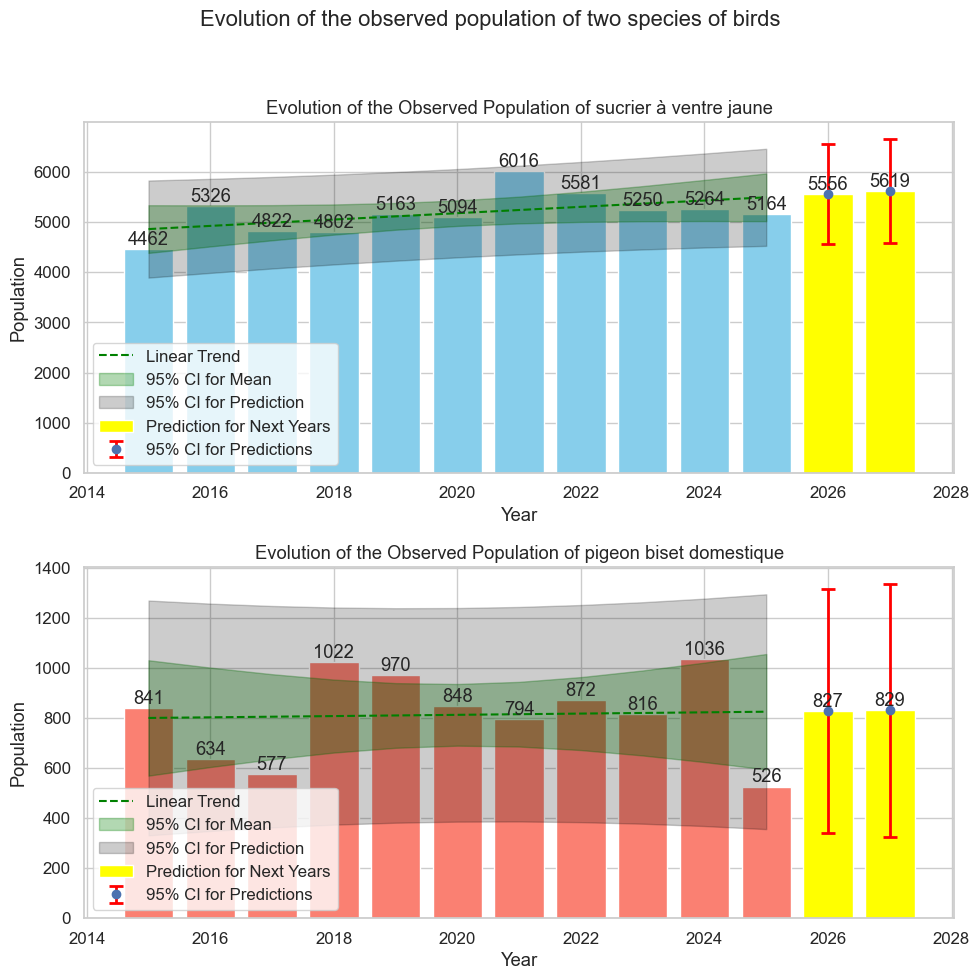

In [46]:
# Finally let's get interested to the evolution of those species of birds
fig, axes = plt.subplots(2, 1, figsize = (10, 10))
plot_with_trend(axes[0], evolutionSpecies[specieStdMin].keys(), evolutionSpecies[specieStdMin], 'skyblue', f'Evolution of the Observed Population of {specieStdMin}')

# Plot maxEvol
plot_with_trend(axes[1], evolutionSpecies[specieStdMax].keys(), evolutionSpecies[specieStdMax], 'salmon', f'Evolution of the Observed Population of {specieStdMax}')
plt.suptitle("Evolution of the observed population of two species of birds" )
plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.savefig("figures/evolution_species_std_habitat.jpeg")
plt.show()

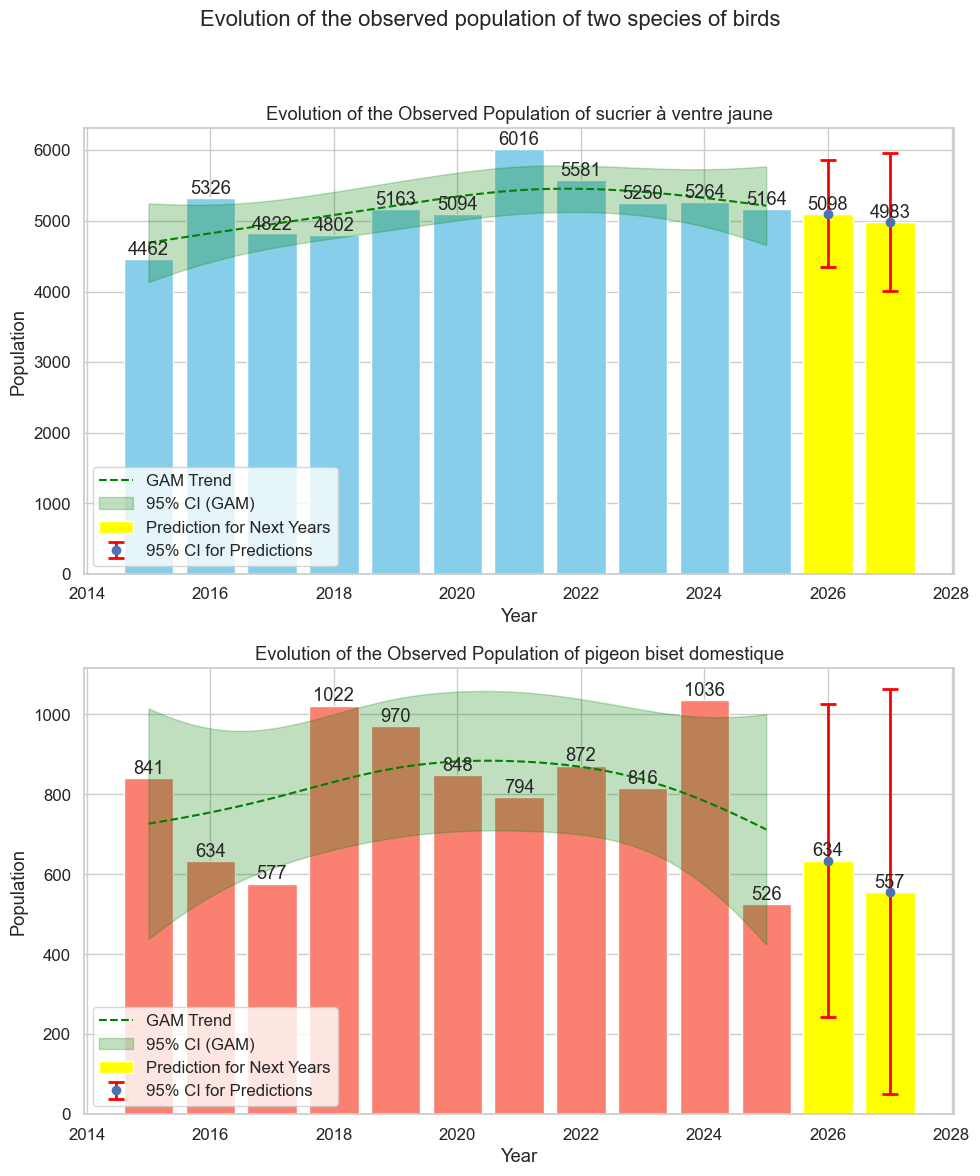

In [47]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
plot_with_gam(ax1, evolutionSpecies[specieStdMin].keys(), evolutionSpecies[specieStdMin], 'skyblue', f'Evolution of the Observed Population of {specieStdMin}')
plot_with_gam(ax2, evolutionSpecies[specieStdMax].keys(), evolutionSpecies[specieStdMax], 'salmon',f'Evolution of the Observed Population of {specieStdMax}')
plt.suptitle("Evolution of the observed population of two species of birds" )
plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.savefig("figures/evolution_species_std_habitat_gam.jpeg")
plt.show()

We can notice that their population is almost steady (it does not increase that much, nor does it decreseases).

We can also notice that for the "pigeon biset domestique", the Confidence Interval is huge, so we can deduce that for this species, the linear model is very uncertain and is therefore not a good fit.